# Google Earth Engine Panel Data Creation

## Initialize

In [1]:
# !pip install geemap
#!pip install ee

In [2]:
# !pip install uszipcode

In [195]:
#GEE specific
import ee
import geemap
import math

#plotting and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from time import time


In [196]:
#Initialize Google Earth Engine
#ee.Authenticate() #just needed the 1st time
ee.Initialize()

In [197]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

## Load Feature Collection - Shapefiles

In [198]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [199]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7f9d5a908a00>,
 <ee.featurecollection.FeatureCollection at 0x7f9d5a9083a0>)

In [200]:
#Income Data
la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")

## Load NAIP Imagery

In [201]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [202]:
def get_images(param_dict):
    source_image_collection = params['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

    
    

In [203]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

{'2010_la_county': <ee.image.Image at 0x7f9d2854b940>,
 '2010_sc_county': <ee.image.Image at 0x7f9d2854bb20>,
 '2012_la_county': <ee.image.Image at 0x7f9d2854bd00>,
 '2012_sc_county': <ee.image.Image at 0x7f9d2854bee0>,
 '2014_la_county': <ee.image.Image at 0x7f9d2854f100>,
 '2014_sc_county': <ee.image.Image at 0x7f9d2854f2e0>,
 '2016_la_county': <ee.image.Image at 0x7f9d2854f4c0>,
 '2016_sc_county': <ee.image.Image at 0x7f9d2854f6a0>,
 '2018_la_county': <ee.image.Image at 0x7f9d2854f880>,
 '2018_sc_county': <ee.image.Image at 0x7f9d2854fa60>,
 '2020_la_county': <ee.image.Image at 0x7f9d2854fc40>,
 '2020_sc_county': <ee.image.Image at 0x7f9d2854fe20>}

In [204]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [205]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [206]:
#test to see if NDVI plot looks correct (define a different location in santa clara county just for visibility)
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [207]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Labeled Data

In [208]:
## Loading feature collections from Google Earth Engine

#water = ee.FeatureCollection("projects/california-lawn-detection/assets/water_torrance")
water_training = ee.FeatureCollection("projects/california-lawn-detection/assets/water_training")
trees_training = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_training")
grass_training = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_training")
turf_training = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_training")
#pv_training = ee.FeatureCollection("projects/california-lawn-detection/assets/pv_training")
impervious_training = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_training").limit(50)
soil_training = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_training").limit(50)

LABELED_SET = water_training.merge(trees_training).merge(grass_training).merge(turf_training).merge(impervious_training).merge(soil_training)

In [209]:
water_test = ee.FeatureCollection("projects/california-lawn-detection/assets/water_test")
vegetation_trees_test = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_test")
vegetation_grass_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_test")
turf_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_test")
#pv_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/pv_test")
impervious_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_test")
soil_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_test")

TEST_SET = water_test.merge(vegetation_trees_test).merge(vegetation_grass_test).merge(turf_test).merge(impervious_test).merge(soil_test)

## Build Training Set

In [210]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_lacounty']

In [211]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 
         'G', 
         'B', 
         'N', 
         'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy', 
         'N_Contrast', 
         'N_Gearys']

train_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

test_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': TEST_SET,
  'properties': [LABEL],
  'scale': 1
})

In [212]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [213]:
print("Training Set Size in Pixels", train_data.aggregate_count('R').getInfo())

Training Set Size in Pixels 169069


In [214]:
print("Test Set Size in Pixels", test_data.aggregate_count('R').getInfo())

Test Set Size in Pixels 97964


## Machine Learning Model

In [215]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 200, minLeafPopulation = 5, bagFraction= 0.7)\
                   .train(train_data, LABEL, BANDS)
clf

In [216]:
training_image_classified = TRAINING_IMAGE.select(BANDS)\
                                          .classify(clf)


In [217]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [218]:
training_image_classified.bandNames().getInfo()

['classification']

In [220]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))

In [221]:
polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', '90027'))

In [222]:
zip_classified = training_image_classified.clip(polygon)

In [223]:
Map.addLayer(zip_classified,{'min': 1, 'max': 7, 'palette': legend_colors}, 'Zip Classification')

In [224]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [228]:
combined_img = ee.ImageCollection([images['2020_la_county'], zip_classified]).mosaic()

In [229]:
combined_img.bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [236]:
aoi = ee.Geometry.Polygon(
  [[[-118.2, 33.9],
       [-118.2, 33.8],
       [-118.1, 33.8],
       [-118.1, 33.9]]], None, False)

img = (
    ee.ImageCollection('USDA/NAIP/DOQQ')
    .filterDate('2020-01-01', '2020-12-31')
    .select(['R', 'G', 'B']).median().clipToBoundsAndScale(aoi, 500,500)
)



(500, 500)
(500, 500)
(500, 500)
(500, 500, 1)
(500, 500, 1)
(500, 500, 1)
(500, 500, 3)


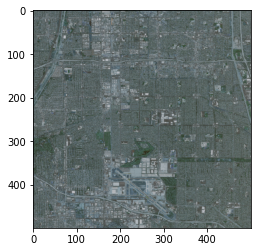

In [237]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# # Get individual band arrays.
band_arr_b4 = band_arrs.get('R')
band_arr_b5 = band_arrs.get('G')
band_arr_b6 = band_arrs.get('B')

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
# rgb_img_test = (255*((rgb_img - 100)/3500)).astype('uint8')
plt.imshow(rgb_img.astype('int'))
plt.show()

In [239]:
aoi = ee.Geometry.Polygon(
  [[[-118.2, 33.9],
       [-118.2, 33.8],
       [-118.1, 33.8],
       [-118.1, 33.9]]], None, False)

img = training_image_classified.clipToBoundsAndScale(aoi, 500,500)



In [253]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# # Get individual band arrays.
band_arr_b4 = band_arrs.get('classification')


# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
print(np_arr_b4.shape)


# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
print(np_arr_b4.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np_arr_b4
print(rgb_img.shape)


(500, 500)
(500, 500, 1)
(500, 500, 1)


In [255]:
classification_image = rgb_img

In [256]:
classification_image.max(), classification_image.min()

(5, 0)

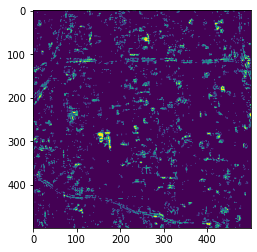

In [265]:
plt.imshow((classification_image ==2)[:,:,0])